In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from glob import glob
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import os
# import cv2
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
from pathlib import Path

if os.name == 'nt':
    file_path = 'C:\\JL\\Master\\DSE_I2100_Applied Machine Learning and Data Mining\\Final_Project\\lgg-mri-segmentation\\'
else:
    file_path = os.path.join(os.path.expanduser("~"), "Downloads/")

In [3]:
mask_img = glob(file_path + os.path.join('kaggle_3m','*','*_mask*'))
train_img = [file.replace('_mask', '') for file in mask_img]

In [4]:
def label(mask):
    value = np.max(imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_img,
                   "mask": mask_img,
                  "label":[label(x) for x in mask_img]})

In [5]:
len(train_img)

3929

In [6]:
df.head()

,image,mask,label
0,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,0
1,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,1
2,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,1
3,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,1
4,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,C:\JL\Master\DSE_I2100_Applied Machine Learnin...,1


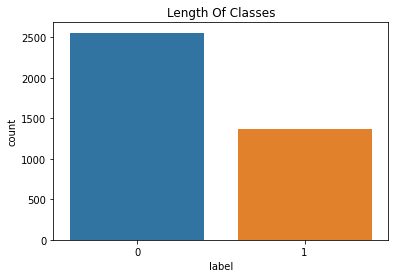

In [7]:
sns.countplot(data=df,x=df['label'])
plt.title('Length Of Classes')
plt.show()

# EDA

In [8]:
# Save images to a list
from skimage.color import rgb2gray
from skimage.io import imread
IMAGE_LIST = [ imread(path) for path in df["image"]  ]
GRAY_IMAGE_LIST = [rgb2gray(rgb_img) for rgb_img in IMAGE_LIST]

IMAGE_LIST = np.array(IMAGE_LIST)
GRAY_IMAGE_LIST = np.array(GRAY_IMAGE_LIST)

In [9]:
IMAGE_LIST.shape

(3929, 256, 256, 3)

## Inspect mage size

In [ ]:
IMAGE_WIDTH_LIST = []
IMAGE_HEIGHT_LIST = []

for path in df['image']:
  IMAGE_WIDTH_LIST.append(imread(path).shape[0])
  IMAGE_HEIGHT_LIST.append(imread(path).shape[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
width_hist = axes[0].hist(IMAGE_WIDTH_LIST)
height_hist = axes[1].hist(IMAGE_HEIGHT_LIST)
axes[0].set_title("Histogram of image width")
axes[1].set_title("Histogram of image height")

## View first 5 images

In [ ]:
def show_image_and_mask(img_path, mask_path):
    rgb_img = imread(img_path)
    gray_img = rgb2gray(rgb_img)
    mask_img = imread(mask_path)

    fig, axes = plt.subplots(1, 3, figsize=(10, 8))
    ax = axes.ravel()
    ax[0].imshow(rgb_img)
    ax[0].set_title("Original")
    ax[1].imshow(gray_img, cmap=plt.cm.gray)
    ax[1].set_title("Grayscale")
    ax[2].imshow(mask_img)
    ax[2].set_title("Mask")
    fig.tight_layout()

In [ ]:
for idx in range(5):
    test_img = df.iloc[idx, 0]
    test_img_mask = df.iloc[idx, 1]
    show_image_and_mask(test_img, test_img_mask)

## Histogram of pixels

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
rgb_pixel_hist = axes[0].hist(IMAGE_LIST.reshape(-1))
gray_pixel_hist = axes[1].hist(GRAY_IMAGE_LIST.reshape(-1))
axes[0].set_title("Histogram of pixels in RGB images")
axes[1].set_title("Histogram of pixels in gray images")

# Preliminary Test

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense


In [11]:
dataset = IMAGE_LIST
label = np.array(df["label"].values).astype(int)

In [12]:
print(dataset.shape)
print(label.shape)

(3929, 256, 256, 3)
(3929,)


In [13]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [14]:
# from keras.utils import normalize
# X_train = normalize(X_train, axis=1)
# X_test = normalize(X_test, axis=1)
X_train = X_train / 255.
X_test = X_test / 255.

In [15]:
INPUT_SHAPE = (256, 256, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid')) 

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',             #also try adam
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [22]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [23]:
import tensorflow as tf
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""
# sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

# with tf.device('/CPU:0'):
#     history = model.fit(X_train, 
#                             y_train, 
#                             batch_size = 32, 
#                             verbose = 1, 
#                             epochs = 20,      
#                             validation_data=(X_test,y_test),
#                             shuffle = True
#                         )
history = model.fit(X_train, 
                            y_train, 
                            batch_size = 32, 
                            verbose = 1, 
                            epochs = 20,      
                            validation_data=(X_test,y_test),
                            shuffle = True
                        )

Epoch 1/20
99/99 [==============================] - 7s 68ms/step - loss: 0.2883 - accuracy: 0.8533 - val_loss: 0.2775 - val_accuracy: 0.8677
Epoch 2/20
99/99 [==============================] - 7s 67ms/step - loss: 0.2649 - accuracy: 0.8753 - val_loss: 0.2795 - val_accuracy: 0.8766
Epoch 3/20
99/99 [==============================] - 7s 66ms/step - loss: 0.2298 - accuracy: 0.8915 - val_loss: 0.2661 - val_accuracy: 0.8715
Epoch 4/20
99/99 [==============================] - 7s 67ms/step - loss: 0.2211 - accuracy: 0.9055 - val_loss: 0.2328 - val_accuracy: 0.8893
Epoch 5/20
99/99 [==============================] - 7s 67ms/step - loss: 0.2207 - accuracy: 0.9001 - val_loss: 0.2229 - val_accuracy: 0.9008
Epoch 6/20
99/99 [==============================] - 7s 67ms/step - loss: 0.1822 - accuracy: 0.9173 - val_loss: 0.2277 - val_accuracy: 0.8957
Epoch 7/20
99/99 [==============================] - 7s 67ms/step - loss: 0.1685 - accuracy: 0.9281 - val_loss: 0.2259 - val_accuracy: 0.9059
Epoch 8/20
99

In [26]:
with tf.device('/CPU:0'):
    _, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

25/25 [==============================] - 8s 313ms/step - loss: 0.3018 - accuracy: 0.9097
Accuracy =  90.96692204475403 %


In [ ]:
mythreshold=0.5
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [ ]:
import tensorflow as tf

len(tf.config.experimental.list_physical_devices("GPU"))

In [ ]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

In [ ]:
import tensorflow as tf
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)